## GENDER INCOME GAP

you may know that it is estimated that women earn about 78% of men in the same job position. 
Can we test that on NYC income data? Can we turn that into a prediction: if you get hired at a certain stipend as a men, what should you expect to make as a woman? (or from the point of view of a job employer, perhaps not one with a very strong moral compass, what should I offer a woman job candidate, given what I would offer a man for the same job?)




In [2]:
from __future__ import print_function, division
import sys
import os
import numpy 
import pylab as pl
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
import json
import os
# Was originally 'PUI2016', changed to  PUIDATA'
s = json.load( open(os.getenv('PUIDATA')+"/fbb_matplotlibrc.json") )
pl.rcParams.update(s)



%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


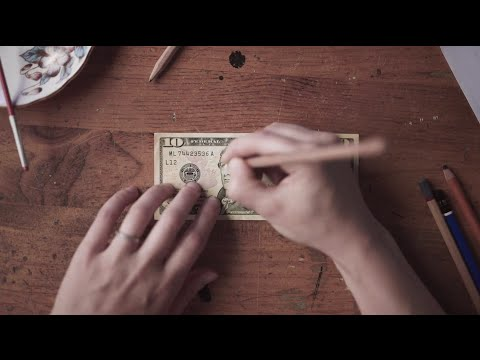

In [3]:
#The gender gap(non mandatory viewing)
from IPython.display import YouTubeVideo
YouTubeVideo("G_ikzQM93W8")

the Census data on income
http://www.census.gov/hhes/www/cpstables/032015/perinc/pinc03_000.htm

I posted the relevant data on the class webpage here : http://cosmo.nyu.edu/~fb55/PUI2016/data

# 1. Create two python dictionaries to store your data. 

In [4]:
url = "http://cosmo.nyu.edu/~fb55/PUI2016/data/"

In [5]:
#assambling file name from known and variable pieces
#e.g. http://cosmo.nyu.edu/~fb55/PUI2016/data/pinc08_2_1_1.xls
#storing data in 2 dictionaries
allmales={}
allfemales={}
fnamedict = {'all' : 1, 'white' : 4, 'black' : 6, 
             'asian' : 8, 'hispanic' : 9,
             'f' : (allfemales, 3), 'm' : (allmales, 2)}

for k in ['f', 'm']:
    for race in fnamedict:
        if not race == 'f' and not race == 'm':
            print (race)
            fnamedict[k][0][race] = pd.read_excel(url + 
                                        '/pinc08_%d'%fnamedict[k][1] + 
                                        '_1_%d'%fnamedict[race] + 
                                        '.xls', 
                                        header=(9))
        
allfemales.keys(), allmales.keys()
col = {'all': 'IndianRed', 'hispanic': 'SteelBlue', 'black': 'blue', 
      'white': 'DarkOrange', 'asian': 'olive'}

all
hispanic
black
asian
white
all
hispanic
black
asian
white


In [6]:
# Descriptive phase: 
# just run this cell to get an idea of the data
for k,v in allfemales.items():
    print("#####", k)
    print(v.describe())
for k,v in allmales.items():
    print("#####", k)
    print(v.describe())

##### hispanic
       Total with Income  $1 to $2,499 or loss  $2,500 to $4,999  \
count          46.000000             46.000000         46.000000   
mean         1908.739130            274.282609        137.717391   
std          3688.718088            568.547923        199.157298   
min             1.000000              0.000000          0.000000   
25%                  NaN                   NaN               NaN   
50%                  NaN                   NaN               NaN   
75%                  NaN                   NaN               NaN   
max         14034.000000           2704.000000        783.000000   

       $5,000 to $7,499  $7,500 to $9,999  $10,000 to $12,499  \
count         46.000000         46.000000           46.000000   
mean         154.043478        188.913043          175.173913   
std          259.111813        321.948569          341.577016   
min            0.000000          0.000000            0.000000   
25%                 NaN               NaN      

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


       Total with Income  $1 to $2,499 or loss  $2,500 to $4,999  \
count          46.000000             46.000000         46.000000   
mean        12310.782609           2214.586957        673.413043   
std         19885.397175           5970.622977        776.907047   
min            76.000000              0.000000          4.000000   
25%                  NaN                   NaN               NaN   
50%                  NaN                   NaN               NaN   
75%                  NaN                   NaN               NaN   
max         74382.000000          30286.000000       2583.000000   

       $5,000 to $7,499  $7,500 to $9,999  $10,000 to $12,499  \
count         46.000000         46.000000           46.000000   
mean         781.195652        971.630435         1036.956522   
std         1023.663283       1566.965750         1730.981173   
min            0.000000          0.000000            0.000000   
25%                 NaN               NaN                 NaN 

# 2. exploratory phase


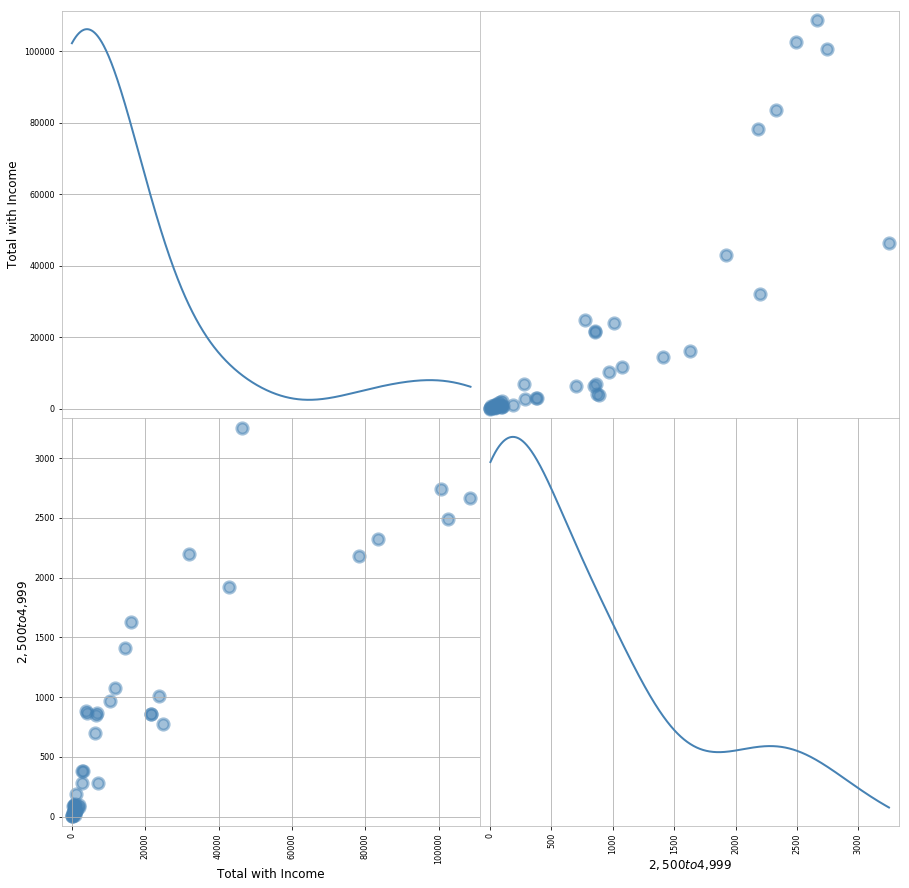

In [7]:

fig = pd.scatter_matrix(allmales['all']
                   [[u'Total with Income',u'$2,500 to $4,999',
                     u'Median income',u'Gini ratio']],
                   linewidth= 3, s=500, figsize=(15,15), 
                        diagonal='kde')                

### Figure 1: Scatter matrix. Each numerical dataframe column is plotted against each other, and the diagonal plots are the Kernel Distributions Estimates of the distribution. Columns of interest are 'Total with Income',  'Median Income', 'Gini ratio', and '$2,500 to $4,999' as a single representative income bracket. 

Only total income and the '$2,500 to $4,999' bracket host numerical values in this dataframe and can be plotted at this time.

In [8]:
# removing non real (i.e. non numerical) values from dataframes
for gender in [allmales, allfemales]:
    for k in gender:
        # find non real values in the dataframe with applymap
        isreal  = gender[k].applymap(np.isreal)
        for c in gender[k].columns :
            #if some but not all values in column are real
            #replace the non real ones
            if isreal.sum()[c] > 0 and \
            isreal.sum()[c] < gender[k].shape[0]:
                gender[k][c][~isreal[c]] =  np.nan
                gender[k][c] = gender[k][c].astype(float)
                


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# now you can plot the dataframe values with a scatter plot 
 just like I tried to do above
 please plot is and write a DESCRIPTIVE caption for the plot in a cell below it

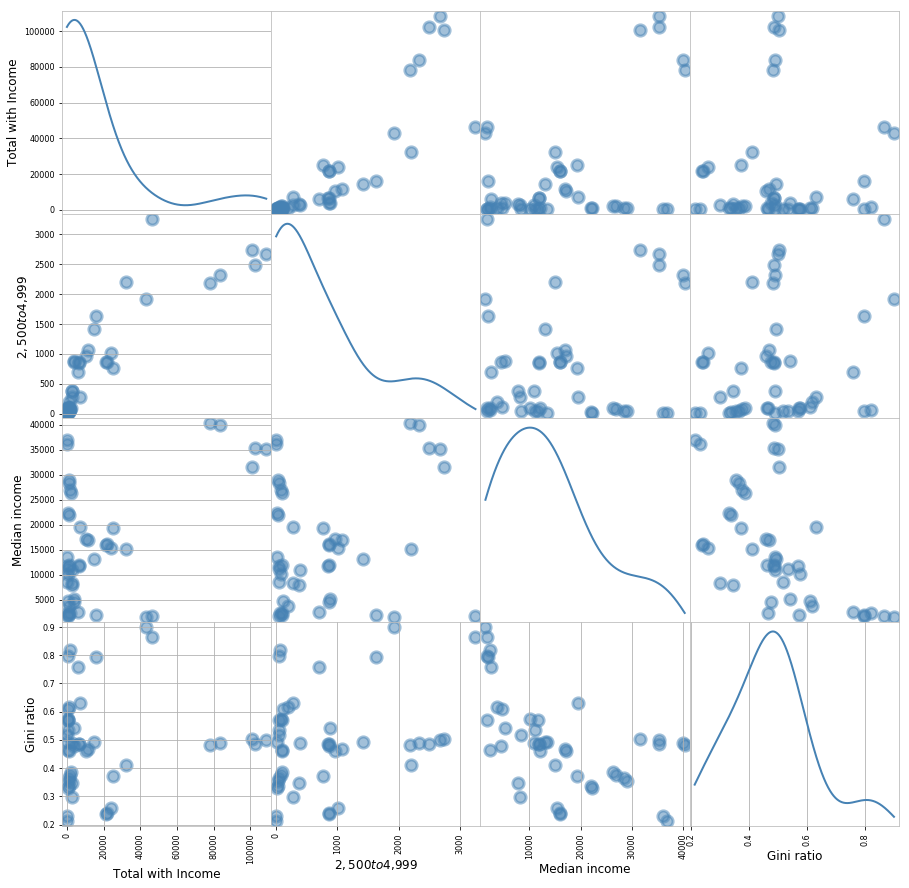

In [9]:
fig = pd.scatter_matrix(allmales['all']
                   [[u'Total with Income',u'$2,500 to $4,999',
                     u'Median income',u'Gini ratio']],
                   linewidth= 3, s=500, figsize=(15,15), 
                        diagonal='kde')                

### Figure 2: Scatter matrix. As Figure 1, but after data cleaning more columns can be plotted. All columns that are thought to be of possible interest, 'Total with Income', 'Median Income', 'Gini ratio', and '2,500to4,999' are now plotted. The most obvious pattern is the correlation of '2,500to4,999' income and 'Total with income'

## 3. to see how the male and female income relate to each other plot the Total Median Income (from any source of revenue) of females vs the Total Median Income of males, race by race (one data point per race)

## also plot the 1-1 line: the diagonal that corresponds to men and women getting the same pay

(make the plot and describe it in a "caption" in the cell below the plot)

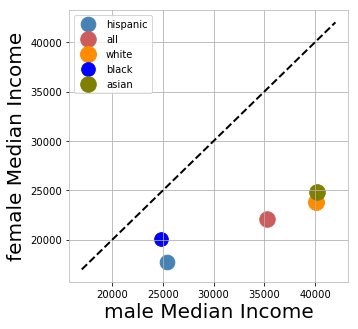

In [10]:
#plotting the Total median incame by race and
#and adding a 1-1 regression line: how things would be if the income was gender unbiased

#in the same loop: storing the values of each datapoint in 2 arrays
all_m = np.zeros(len(allmales) + 1)
all_f = np.zeros(len(allmales) + 1)
    

#make sure the figure is squares, 
#so that the income equality ilke is in fact a diagonal 45deg line 
#and income equalities can be picked out by eye
pl.figure(figsize = (5,5))
for i, (k, v) in enumerate(allmales.items()):
    pl.scatter(allmales[k]['Median income'][1],
                allfemales[k]['Median income'][1],
                s=150*allmales[k]['Median income'][1] / \
                allfemales[k]['Median income'][1],
                c=col[k], label=k)
    all_m[i] = allmales[k]['Median income'][1]
    all_f[i] = allfemales[k]['Median income'][1]
pl.plot([17000, 42000], [17000, 42000],'k--')
pl.xlabel('male Median Income', fontsize=20)
pl.ylabel('female Median Income', fontsize=20)
pl.legend(loc=2)



### Figure 3: Median income of American females is plotted against median income of males for 4 ethnic groups (see legend for details, self-reported ethnicity), and for all people. The diagonal black dashed line represents income equality: inequalities are larger at larger income. The income distributes roughly linearly in the plot, motivating the attempt to fit it with a line and using the line slope as a metric of inequality.

In [11]:
print ("male and female income:\n", all_m, all_f)

male and female income:
 [ 25411.  35228.  40122.  24855.  40153.      0.] [ 17762.  22063.  23780.  20044.  24840.      0.]


# 4. Fit the data with a line.


In [14]:
#pl.plot(newx, np.poly1d(np.ployfit(x, y, 1))(newx)

def line (x, pars):
    '''Creates the dependent variables of a line
    Arguments:
        x: series, independent variable
        pars: series of 2 paramters, slope and intercept
    Return:
        dependent variable array
    '''
    if not isinstance(x, numpy.ndarray) and not isinstance(x, int) \
        and not isinstance(x, float):
        print ('You must pass an array or a single number for the dependent variable')
    if not pars.shape == (2,):
        print ('You must pass a 1D series of 2 parameters in pars')
    a, b = pars
    y = a * x + b
    #this would be a function that creates a line given parameters, 
    #like we did in class
    
    return y

def residuals(pars, data, model, error=None):
    '''Calculates the residuals between model and data
    Arguments:
        data: series - 1D array of datapoints
        model: series - 1D array of model predictions
        error (optional): series - 1D array of errors on data 
    Returns:
        sum of residuals square'''
    
    residuals = (line(data, pars) - model)**2
    if error:
        residuals = residuals / error**2
    
    return residuals.sum()

p0 = (0.5,1000)

#here the model is the female income given the male income: a regression line
##important!! never work with very large numbers! always try to reduce your numbers to ~unity
result = minimize(residuals, p0, args=(all_m/1e4, all_f/1e4))
result

      fun: 0.20531626415064716
 hess_inv: array([[ 0.04362385, -0.12050964],
       [-0.12050964,  0.41625005]])
      jac: array([  5.58793545e-09,   1.86264515e-09])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 7
     njev: 11
   status: 0
  success: True
        x: array([ 0.59384348,  0.16746933])

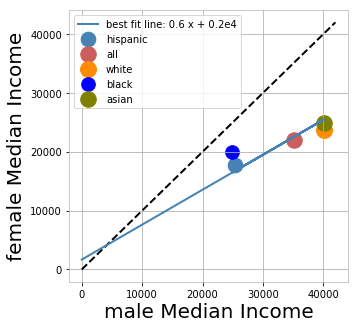

In [15]:
pl.figure(figsize = (5,5))
for i, (k, v) in enumerate(allmales.items()):
    pl.scatter(allmales[k]['Median income'][1],
                allfemales[k]['Median income'][1],
                s=150*allmales[k]['Median income'][1] / \
               allfemales[k]['Median income'][1],
                c=col[k], label=k)
pl.plot([0, 42000], [0, 42000],'k--')
pl.xlabel('male Median Income', fontsize=20)
pl.ylabel('female Median Income', fontsize=20)


pl.plot(all_m, all_m * result.x[0] + result.x[1] * 1e4, label="best fit line: %.1f x + %.1fe4"\
       %(result.x[0], result.x[1]))
pl.legend(loc=2)

### Figure 4: as figure 3, but with the addition of the best line fit obtained via residuals minimization (blue solid line)

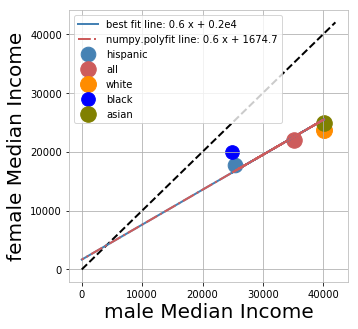

In [16]:
#also calculate the numpy polyfit line
beta1_np, beta0_np = np.polyfit(all_m, all_f, 1) 

pl.figure(figsize = (5,5))
for i, (k, v) in enumerate(allmales.items()):
    pl.scatter(allmales[k]['Median income'][1],
                allfemales[k]['Median income'][1],
                s=150*allmales[k]['Median income'][1] / \
               allfemales[k]['Median income'][1],
                c=col[k], label=k)
pl.plot([0, 42000], [0, 42000],'k--')
pl.xlabel('male Median Income', fontsize=20)
pl.ylabel('female Median Income', fontsize=20)


pl.plot(all_m, all_m * result.x[0] + result.x[1] * 1e4, label="best fit line: %.1f x + %.1fe4"\
       %(result.x[0], result.x[1]))
pl.plot(all_m, all_m * beta1_np + beta0_np, '-.',
        label="numpy.polyfit line: %.1f x + %.1f"\
       %(beta1_np, beta0_np))
pl.legend(loc=2)

### Figure 5: as figure 4, but with the addition of the best line fit obtained with numpy polyfit (dotted dashed red line). Numpy polyfit is a residual minimization routine and it returns the same fit as the residual minimization function I wrote: the lines fully overlap.

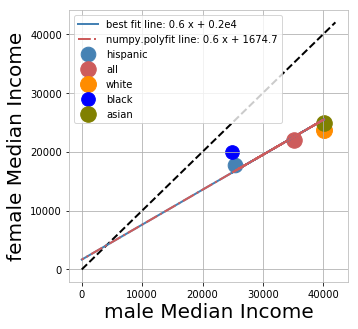

In [17]:
#also could use statsmodels
smresult = sm.OLS(all_f, sm.add_constant(all_m)).fit()
beta0_sm, beta1_sm = smresult.params

pl.figure(figsize = (5,5))
for i, (k, v) in enumerate(allmales.items()):
    pl.scatter(allmales[k]['Median income'][1],
                allfemales[k]['Median income'][1],
                s=150*allmales[k]['Median income'][1] / \
               allfemales[k]['Median income'][1],
                c=col[k], label=k)
pl.plot([0, 42000], [0, 42000],'k--')
pl.xlabel('male Median Income', fontsize=20)
pl.ylabel('female Median Income', fontsize=20)


pl.plot(all_m, all_m * result.x[0] + result.x[1] * 1e4, label="best fit line: %.1f x + %.1fe4"\
       %(result.x[0], result.x[1]))
pl.plot(all_m, all_m * beta1_sm + beta0_sm, '-.',
        label="numpy.polyfit line: %.1f x + %.1f"\
       %(beta1_np, beta0_np))
pl.legend(loc=2)

### Figure 6: as figure 5, but with the statsmodels.api.OLS best line fit in place of the numpy polyfit (dotted dashed red line). Once again the solutions are fully consistent and the lines  overlap.

In [18]:
#this is the analytical best regression line, with an added datapoint at through the origin. 
# one could argue for the vailidity of forcing the line through the origin. 
#In a problem like this there is no obvious best choice.
all_males=np.array([0., allmales['all']['Median income'][1],
                    allmales['white']['Median income'][1],
                    allmales['black']['Median income'][1],
                     allmales['hispanic']['Median income'][1],
                    allmales['asian']['Median income'][1]])

all_females=np.array([0.] + [allfemales[k]['Median income'][1] \
                             for k in ['all', 'white', 'black',
                                     'hispanic','asian']])
cor = stats.spearmanr(all_males, all_females)
beta1 = cor[0] * all_females.std() / all_males.std()
beta0 = all_females.mean() - beta1 * all_males.mean()

cor = stats.spearmanr(all_males[1:], all_females[1:])
beta1_non0 = cor[0] * all_females[1:].std() / all_males[1:].std()
beta0_non0 = all_females[1:].mean() - beta1_non0 * all_males[1:].mean()



## and plot the line corresponding to the analytical regression to compare it with the result of your numerical one (remember: a line is y = beta0 + beta1 * x)

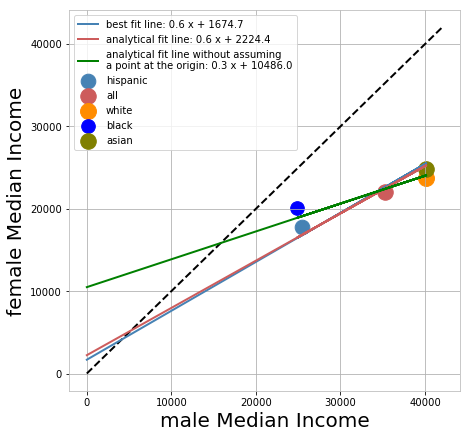

In [19]:
pl.figure(figsize = (7,7))
for i, (k, v) in enumerate(allmales.items()):
    pl.scatter(allmales[k]['Median income'][1],
                allfemales[k]['Median income'][1],
                s=150*allmales[k]['Median income'][1] / \
               allfemales[k]['Median income'][1],
                c=col[k], label=k)
pl.plot([0, 42000], [0, 42000],'k--')
pl.xlabel('male Median Income', fontsize=20)
pl.ylabel('female Median Income', fontsize=20)


pl.plot(all_m, all_m * result.x[0] + result.x[1] * 1e4, label="best fit line: %.1f x + %.1f"\
       %(result.x[0], result.x[1]*10000))
pl.plot(all_m, all_m * beta1 + beta0, label="analytical fit line: %.1f x + %.1f"\
       %(beta1, beta0))
pl.plot(all_m, all_m * beta1_non0 + beta0_non0, 
        label="analytical fit line without assuming \n" + "a point at the origin: %.1f x + %.1f"\
       %(beta1_non0, beta0_non0))

pl.legend(loc=2)

### Figure 7: as figure 4, but with the addition of the best line fit obtained analytically by including a point through the origin (0,0) and by not including a point through the origin. Naturally at no male income there is no female income, but in practice there should be no income below minimum wage, and minimum wage is the same for male and female. So while a point through the origin is natural the point at 0-income is an-ill defined point in this problem. Assuming a point at (0,0) or not dramatically change the fit, from a slope of 0.3 to a slope of 0.6! This is because (0,0) has a high leverage, being at the edge of the distribution and significantly below a line that fits the remaining points.

(Notice: assuming a point at (0,0) is not the same as forcing the solution through the origin!)

# 5. let's now see if all forms of income lead to a different fit. 



In [20]:
#generating arrays of all income sources
all_males_allincomes = np.array(
    np.concatenate([allmales['all']['Median income'][:].values,
                    allmales['white']['Median income'][:].values,
                    allmales['black']['Median income'][:].values,
                    allmales['hispanic']['Median income'][:].values,
                    allmales['asian']['Median income'][:].values]).flatten())

all_females_allincomes = np.array(
    np.concatenate([allfemales['all']['Median income'][:].values,
                    allfemales['white']['Median income'][:].values,
                    allfemales['black']['Median income'][:].values,
                    allfemales['hispanic']['Median income'][:].values,
                    allfemales['asian']['Median income'][:].values]).flatten())

#creating a masking to remove NaN values if needed
mask = ~np.isnan(all_males_allincomes) * ~np.isnan(all_females_allincomes)


In [21]:
#I will fit it with the function I created, but any fit would be ok 
#since we show they are all consistent solutions


#initial value set to the fit for the median income
p0 = result.x
result_all = minimize(residuals, p0, args=(all_males_allincomes[mask]/1e4, 
                                       all_females_allincomes[mask]/1e4))

#initial values set to th fit of the median income not including (0,0)
#I do this to test robustness to the initial conditions
p0 = (beta0_non0, beta1_non0)

result_all_non0 = minimize(residuals, p0, args=(all_males_allincomes[mask]/1e4, 
                                       all_females_allincomes[mask]/1e4))
print (result_all, result_all_non0)


      fun: 14.49793008607594
 hess_inv: array([[ 0.0020943 , -0.00313219],
       [-0.00313219,  0.00749342]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([ 0.60902051,  0.14930395])       fun: 14.49793008607594
 hess_inv: array([[ 0.00209439, -0.00313226],
       [-0.00313226,  0.00749348]])
      jac: array([ -2.38418579e-07,   0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 7
     njev: 15
   status: 0
  success: True
        x: array([ 0.60902051,  0.14930395])


In [22]:
smresult_forced0 = sm.OLS(all_females_allincomes[mask], 
                          all_males_allincomes[mask],
                          hasconst=False).fit()
smforced0 = smresult_forced0.params


#### the results of the regression are consistent regardless of the initial guess, and they are similar to the fit to median income

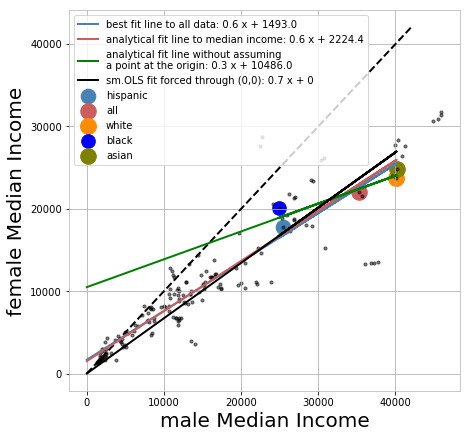

In [23]:
pl.figure(figsize = (7,7))
for i, (k, v) in enumerate(allmales.items()):
    pl.scatter(allmales[k]['Median income'][1],
                allfemales[k]['Median income'][1],
                s=150*allmales[k]['Median income'][1] / \
               allfemales[k]['Median income'][1],
                c=col[k], label=k)
    
pl.scatter(all_males_allincomes[mask], all_females_allincomes[mask], s=10, 
           color = 'k', alpha = 0.5)
pl.plot([0, 42000], [0, 42000],'k--')
pl.xlabel('male Median Income', fontsize=20)
pl.ylabel('female Median Income', fontsize=20)



pl.plot(all_m, all_m * result.x[0] + result.x[1] * 1e4, 
        label="best fit line to all data: " + 
        "%.1f x + %.1f"\
       %(result_all.x[0], result_all.x[1]*10000))
pl.plot(all_m, all_m * result_all.x[0] + result_all.x[1] * 1e4, 
        label="analytical fit line to median income: " + 
        "%.1f x + %.1f"\
       %(beta1, beta0))
pl.plot(all_m, all_m * beta1_non0 + beta0_non0, 
        label="analytical fit line without assuming \n" + "a point at the origin: %.1f x + %.1f"\
       %(beta1_non0, beta0_non0))

pl.plot(all_m, all_m * smforced0 , 'k-',
        label="sm.OLS fit forced through (0,0): %.1f x + 0"\
       %(smforced0))

pl.legend(loc=2)

### Figure 8: as figure 4, but with the income from all sources, plotted as black dots, and the fit line to all income sources, in addition to the best line fit obtained analytically, and by forcing the line to pass through the origin (with statsmodels.api.OLS, solid black line). 
### The fit to all data is consistent with the fit to the median income by ethnicity, and not with the median income fit obtained without assuming the (0,0) point to the median income. 
### The data shows more scatter at high income, with leverage points just below 40,000. Statsmodels can produce leverage point plots

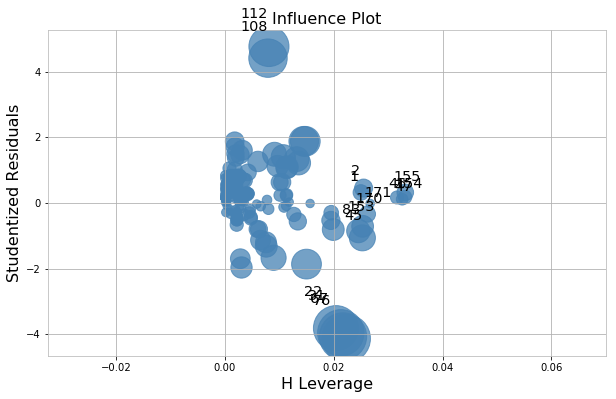

In [24]:
ax = pl.figure(figsize = (10,6)).add_subplot(111)
fig = sm.graphics.influence_plot(smresult_forced0, ax=ax)


### Figure 9: influence plot: the top right of the region is occupeied by plonts with high residual and high leverag: high influence. The three highest influence points are printed below
  

In [25]:
high_influence = [154, 155, 46, 47]
for hip in high_influence:
    print ("high influence point: ", all_males_allincomes[mask][hip], 
          all_females_allincomes[mask][hip])

high influence point:  45926.0 31363.0
high influence point:  45950.0 31802.0
high influence point:  44882.0 30626.0
high influence point:  45554.0 30919.0


## Now pick a stipend, maybe your ideal stipend? 
## and predict what a woman in a position where a man recieves your ideal stipend would make



In [26]:
# my ideal stipend is $175,000
# in a job position where a man makes $175,000 I would make
ideal = 175000.
print ("In a job position where a man makes $175000 I would make $%d"%(
        result_all.x[0] * ideal +  result_all.x[1] * 10000))
print ("A man in a job position where I would make $175000 " + 
       "would make $%d"%(
        (ideal - result_all.x[1] * 10000) / result_all.x[0]))

In a job position where a man makes $175000 I would make $108071
A man in a job position where I would make $175000 would make $284895


## lastly do you have any comments about what these data tell us about race? how you would go about analyzing race differences with these data? (just a few sentences)

Initially we used the data separated by ethnicity, and if ta line to those. There may be differences in gender income inequality for different races, which would bias our first line fit, as well as difference in gender income inequality at different income brackets, and the income is not evenly distributes by ethnicity (as obvious in the median income data we used in the frst several fits). 
Using all income and all kinds of revenue suppresses those biases, but an analysis of the income disparity for different ethnic groups should be carried on by separating the ethnic groups and using all income sources for each ethnic group.

This still would not be sufficient to separate the effects of race on income inequality, and the effects of being in different income brackets on income inequality, since race and income are covariant.
